## chatgpt from sageev

### Step 1: Prepare Your Environment

First, you’ll need to ensure you have Python installed. Then, install the necessary Python packages by running the following command in your terminal or command prompt:

```sh
pip install lxml beautifulsoup4 zipfile36
```

### Step 2: The Python Script

Create a new Python file, let’s call it `extract_midi_start_times.py`, and paste the following code into it:

```python
import zipfile
import os
from lxml import etree
from bs4 import BeautifulSoup
# Path to your Ableton Live Set (.als file). Make sure to use the correct path here.
als_file_path = 'path/to/your/project.als’
# Temporary directory to extract the .als file (which is a zip file)
temp_dir = 'temp_als_extracted’
def unzip_als_file(als_file_path, extract_to):
    with zipfile.ZipFile(als_file_path, 'r’) as zip_ref:
        zip_ref.extractall(extract_to)
def extract_start_times(extracted_folder):
    # Assuming the main composition data is in the 'LiveSet.xml’ file
    live_set_path = os.path.join(extracted_folder, 'LiveSet.xml’)
    if not os.path.exists(live_set_path):
        print(“LiveSet.xml not found. Please check the structure of the extracted .als file.“)
        return
    with open(live_set_path, 'r’, encoding='utf-8’) as file:
        soup = BeautifulSoup(file, 'lxml’)
    midi_clips = soup.find_all('midiclip’)
    for idx, clip in enumerate(midi_clips):
        name = clip.find('name’).get('value’, 'Unknown’)
        start_time = clip.find('currentstart’).get('value’, '0’)
        print(f”MIDI Clip {idx + 1}: '{name}’ starts at {start_time} beats.“)
def main():
    unzip_als_file(als_file_path, temp_dir)
    extract_start_times(temp_dir)
if __name__ == “__main__“:
    main()
```

### Step 3: Run the Script

- Update the `als_file_path` variable in the script with the path to your .als file.
- Run the script by executing `python extract_midi_start_times.py` in your terminal or command prompt.

### What This Script Does:

1. **Unzips the .als File**: It treats the .als file as a zip file and extracts its contents into a temporary directory.
2. **Parses the XML**: It looks for the `LiveSet.xml` file within the extracted contents (note: this might vary based on Ableton Live version, and you may need to adjust the script).
3. **Finds MIDI Clip Start Times**: It searches for `<MidiClip>` elements, extracts their names and start times, and prints this information.

### Caveats and Modifications:

- **Ableton Live Version**: The structure and names within the XML might change with different Ableton Live versions. Adjust the tags you search for based on your version.
- **Error Handling**: This script is a basic demonstration and lacks detailed error handling. Consider adding more robust error checking for production use.
- **File Paths**: This script assumes a simple scenario. Paths and filenames might need adjustment based on your specific setup and Ableton Live version.
  This script provides a starting point, but you may need to tweak it depending on the specifics of your .als files and what exactly you’re trying to extract.


In [1]:
import os
from pathlib import Path
import gzip
from bs4 import BeautifulSoup
import mido
import pretty_midi
from rich.progress import track

from typing import List

In [ ]:
class MidiNote:
    def __init__(
        self, beat: float, duration: float, velocity: int, pitch: int, key_track: str
    ):
        self.beat = beat
        self.duration = duration
        self.velocity = velocity
        self.pitch = pitch
        self.key_track = key_track

    def info(self) -> None:
        print(
            f"Note (t: {self.beat:06.03f}, d: {self.duration:06.03f}, v: {self.velocity:03d}, p: {self.pitch:03d}, k: {self.key_track})"
        )


class MidiClip:
    def __init__(self, tempo: int, time_signature, start, end, notes):
        self.tempo = tempo
        self.time_signature = time_signature
        self.start = start
        self.end = end
        self.notes = notes
        self.beat_times = self._calc_beats(
            tempo, self._b2t(start, tempo), self._b2t(end, tempo)
        )

    def to_mido(self) -> mido.MidiTrack:
        raise NotImplementedError

    def info(self) -> None:
        print(f"{self.tempo} BPM at {self.time_signature[0]}/{self.time_signature[1]}")
        print(f"{len(self.beat_times)} beats: {self.beat_times[:4]}...")
        for n in self.notes[:4]:
            n.info()
        print("...")

    def _calc_beats(
        self, tempo: int, start_time_seconds: float, end_time_seconds: float
    ):
        """
        Calculates the time of each beat within a specified time range.

        Args:
            tempo (int): The tempo of the piece in beats per minute.
            start_time_seconds (float): The start time of the time range in seconds.
            end_time_seconds (float): The end time of the time range in seconds.

        Returns:
            list: A list of floats representing the times of each beat within the specified range.

        Example:
            >>> calc_beats(120, (4, 4), 0.0, 3.0)
            [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
        """

        beat_duration = 60 / tempo
        current_time = start_time_seconds
        beat_times = []

        while current_time <= end_time_seconds:
            beat_times.append(current_time)
            current_time += beat_duration

        return beat_times

    def _b2t(self, time_beats: float, tempo: int) -> float:
        """
        Converts a time in beats to the equivalent time in seconds.

        Args:
            time_beats (float): The time in beats.
            tempo (int): The tempo in beats per minute.

        Returns:
            float: The equivalent time in seconds.

        Example:
            >>> b2t(2.0, 120)
            1.0
        """

        beat_duration_seconds = 60 / tempo

        time_seconds = time_beats * beat_duration_seconds

        return time_seconds

In [ ]:
def extract_gz_to_folder(gz_file_path, destination_folder):
    """
    Extracts a gzip file to a specified folder.

    Parameters:
    gz_file_path (str): The path to the gzip file.
    destination_folder (str): The folder where the file will be extracted.
    """
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    file_name = f"{Path(gz_file_path).stem}.xml"
    extracted_file_path = os.path.join(destination_folder, file_name)

    with gzip.open(gz_file_path, "rb") as gz_file:
        with open(extracted_file_path, "wb") as extracted_file:
            extracted_file.write(gz_file.read())

    print(f"Extracted {gz_file_path} to {extracted_file_path}")

    return extracted_file_path

In [ ]:
def extract_start_times(soup):
    midi_clips = soup.find_all("MidiClip")

    clip_data = {}

    for clip in midi_clips:
        name = clip.get("Id")
        start_beats = int(clip.find("CurrentStart").get("Value"))
        end_beats = float(clip.find("CurrentEnd").get("Value"))
        time_signature_n = clip.find("RemoteableTimeSignature").Numerator.get("Value")
        time_signature_d = clip.find("RemoteableTimeSignature").Denominator.get("Value")
        print(
            f"MIDI Clip {name}: spans beats {start_beats:04d} - {end_beats:07.03f} ({time_signature_n}/{time_signature_d})"
        )


def extract_clips(soup):
    event_list = soup.MainSequencer.ClipTimeable.ArrangerAutomation.Events.children

    tempo = soup.MasterTrack.DeviceChain.Mixer
    if tempo:
        tempo = int(tempo.Tempo.Manual.get("Value"))
    print(f"tempo is {tempo}BPM")

    clips = []

    for clip in event_list:
        if clip.name:
            name = clip.get("Id")
            start_beats = float(clip.find("CurrentStart").get("Value"))
            end_beats = float(clip.find("CurrentEnd").get("Value"))
            time_signature_n = clip.find("RemoteableTimeSignature").Numerator.get(
                "Value"
            )
            time_signature_d = clip.find("RemoteableTimeSignature").Denominator.get(
                "Value"
            )

            print(
                f"MIDI Clip {name}: spans beats {start_beats:04.00f} - {end_beats:07.03f} ({time_signature_n}/{time_signature_d})"
            )

            trax = []
            for key_track in clip.Notes.KeyTracks.children:
                if key_track.name:
                    notes = []
                    pitch = key_track.MidiKey.get("Value")

                    for note in key_track.Notes.children:
                        if note.name:
                            t = float(note.get("Time"))
                            d = float(note.get("Duration"))
                            v = int(note.get("Velocity"))
                            p = int(pitch)
                            k = key_track.get("Id")

                            notes.append(MidiNote(t, d, v, p, k))

                    trax.append(notes)

            concat_trax = [note for sublist in trax for note in sublist]
            sorted_notes = sorted(concat_trax, key=lambda note: note.beat)

            clips.append(
                MidiClip(
                    tempo,
                    (time_signature_n, time_signature_d),
                    start_beats,
                    end_beats,
                    sorted_notes,
                )
            )

    return clips

In [ ]:
# als_file_path = (
#     "../data/ableton/2023-12-20 groove stuff Project/2023-12-20 groove stuff.als"
# )
temp_dir = "tmp/als_extract"

for project in os.listdir("../data/ableton"):
    for file in os.listdir(os.path.join("../data/ableton", project)):
        if file.endswith(".als"):
            als_file_path = os.path.join("../data/ableton/", project, file)
            xml_path = extract_gz_to_folder(als_file_path, temp_dir)

            with open(xml_path, "r", encoding="utf-8") as file:
                soup = BeautifulSoup(file, "xml")

            clipse = extract_clips(soup)

            # for clip in clipse:
            #     clip.info()

In [ ]:
def b2t(time_beats: float, tempo: int) -> float:
    """
    Converts a time in beats to the equivalent time in seconds.

    Args:
        time_beats (float): The time in beats.
        tempo (int): The tempo in beats per minute.

    Returns:
        float: The equivalent time in seconds.

    Example:
        >>> b2t(2.0, 120)
        1.0
    """

    beat_duration_seconds = 60 / tempo

    time_seconds = time_beats * beat_duration_seconds

    return time_seconds

In [2]:
import matplotlib.pyplot as plt
import numpy as np


def draw_piano_roll(piano_roll, beats=[0], fs=100, title="Piano Roll") -> None:
    plt.style.use("dark_background")
    plt.figure(figsize=(12, 8))
    plt.imshow(
        piano_roll, aspect="auto", origin="lower", cmap="magma", interpolation="nearest"
    )
    plt.vlines([b * fs for b in beats], 0, 120, "g", linewidth=1, alpha=0.4)
    plt.title(title)
    plt.xlabel("Time (seconds)")
    plt.ylabel("MIDI Note Number")
    plt.colorbar()

    tick_spacing = 1
    ticks = np.arange(0, len(piano_roll.T) / fs, tick_spacing)
    plt.xticks(ticks * fs, labels=[f"{int(tick)}" for tick in ticks])
    plt.show()


def calc_beats(tempo: int, start_time_seconds: float, end_time_seconds: float):
    beat_duration = 60 / tempo
    current_time = start_time_seconds
    beat_times = []

    while current_time <= end_time_seconds:
        beat_times.append(current_time)
        current_time += beat_duration

    return beat_times


def get_active_beats(beats, start):
    """Finds and returns the number immediately before a given start value and all numbers following it in the list.

    Args:
        beats (list[float]): A list of numeric values representing beats.
        start (float): The start value to search for in the list.

    Returns:
        list[float]: A list containing the value immediately before the start value (if any) and all subsequent values.
        Returns an empty list if the start value is greater than all elements in the list.
    """
    # Find the index of the first number greater than start
    index = next((i for i, beat in enumerate(beats) if beat > start), None)

    # If such a number is found, return the element before it (if it exists) and all following elements
    if index is not None and index > 0:
        return beats[index - 1 :]

    return []

In [7]:
midi_folder_path = "../data/datasets/trimmed midi"
output_folder = "tmp/segs"
dataset_folder = "../data/datasets/careful"

In [ ]:
for midi_file in track(os.listdir(midi_folder_path), "segmenting..."):
    filename = Path(midi_file).stem
    midi_path = os.path.join(midi_folder_path, midi_file)

    # set file bpm properly
    mid = mido.MidiFile(midi_path)
    target_tempo = int(filename.split("-")[1])
    tempo = mido.bpm2tempo(target_tempo)
    mid.tracks[0].insert(0, mido.MetaMessage("set_tempo", tempo=tempo, time=0))
    mid.save(os.path.join(output_folder, midi_file))

    # calculate segments, timings, etc.
    pm = pretty_midi.PrettyMIDI(os.path.join(output_folder, midi_file))
    first_note_time = pm.instruments[0].notes[0].start
    all_beats = calc_beats(target_tempo, 0.0, pm.get_end_time())
    beats = get_active_beats(all_beats, first_note_time)
    len_seg = 8  # in beats
    num_segs = int(np.round(len(beats) / len_seg))
    print(
        f"{midi_file} {len(beats)}/{len_seg} -> {num_segs}s from {beats[0]:.03f}s | {pm.instruments[0].notes[0].start:.03f}s"
    )

    for n in list(range(num_segs)):
        start = n * len_seg
        end = start + len_seg
        seg_beats = beats[start : end + 1]
        # print(f"splitting from {seg_beats[0]:07.03f}s to {seg_beats[-1]:07.03f}s over {len(seg_beats)} beats", seg_beats)

        segment_midi = pretty_midi.PrettyMIDI(initial_tempo=target_tempo)
        instrument = pretty_midi.Instrument(
            program=pm.instruments[0].program,
            name=f"{filename}_{int(start):04d}-{int(end):04d}",
        )

        # add notes from the original MIDI that fall within the current segment
        for note in pm.instruments[0].notes:
            if seg_beats[0] <= note.start < seg_beats[-1]:
                new_note = pretty_midi.Note(
                    velocity=note.velocity,
                    pitch=note.pitch,
                    start=note.start - seg_beats[0],
                    end=note.end - seg_beats[0],
                )
                instrument.notes.append(new_note)

        if len(instrument.notes) == 0:
            print("No notes found in segment, skipping")
            continue

        segment_midi.instruments.append(instrument)
        segment_filename = os.path.join(
            dataset_folder, f"{filename}_{int(start):04d}-{int(end):04d}.mid"
        )
        segment_midi.write(segment_filename)

        # add beat messages
        segment_mido = mido.MidiFile(segment_filename)
        tick_track = mido.MidiTrack()
        last_time = seg_beats[0]
        for i, b in enumerate(seg_beats):
            t = int(mido.second2tick(b - last_time, segment_mido.ticks_per_beat, tempo))
            text = mido.MetaMessage("text", text=f"beat {i}", time=t)
            tick_track.append(text)
            last_time = b
        tick_track.append(mido.MetaMessage("end_of_track", time=t + 1))
        segment_mido.tracks.append(tick_track)
        segment_mido.save(segment_filename)

        # if start == 0:
        #     draw_piano_roll(
        #         segment_midi.get_piano_roll(),
        #         beats=[b - seg_beats[0] for b in seg_beats],
        #         title=segment_filename,
        #     )

In [3]:
import simpleaudio as sa


def tick():
    tick = sa.WaveObject.from_wave_file("../data/tick.wav")
    tick.play()
    return

In [5]:
def change_tempo(midi_file_path: str, do_stretch: bool = True) -> str:
    midi = mido.MidiFile(midi_file_path)
    new_tempo = mido.bpm2tempo(80)
    new_message = mido.MetaMessage("set_tempo", tempo=new_tempo, time=0)
    tempo_added = False

    for track in midi.tracks:
        for msg in track:
            if msg.type == "set_tempo":
                track.remove(msg)
                print(f"removed set tempo message", msg)

        if not tempo_added:
            track.insert(0, new_message)
            print(f"adding message (tempo=80) {new_message}")
            tempo_added = True

    # if no tracks had a set_tempo message and no new one was added, add a new track with the tempo message
    if not tempo_added:
        new_track = mido.MidiTrack()
        print(f"adding message to new track {new_message}")
        new_track.append(new_message)

    new_file_path = os.path.join("tmp/playlist", f"{Path(midi_file_path).stem}.mid")
    midi.save(new_file_path)

    return new_file_path

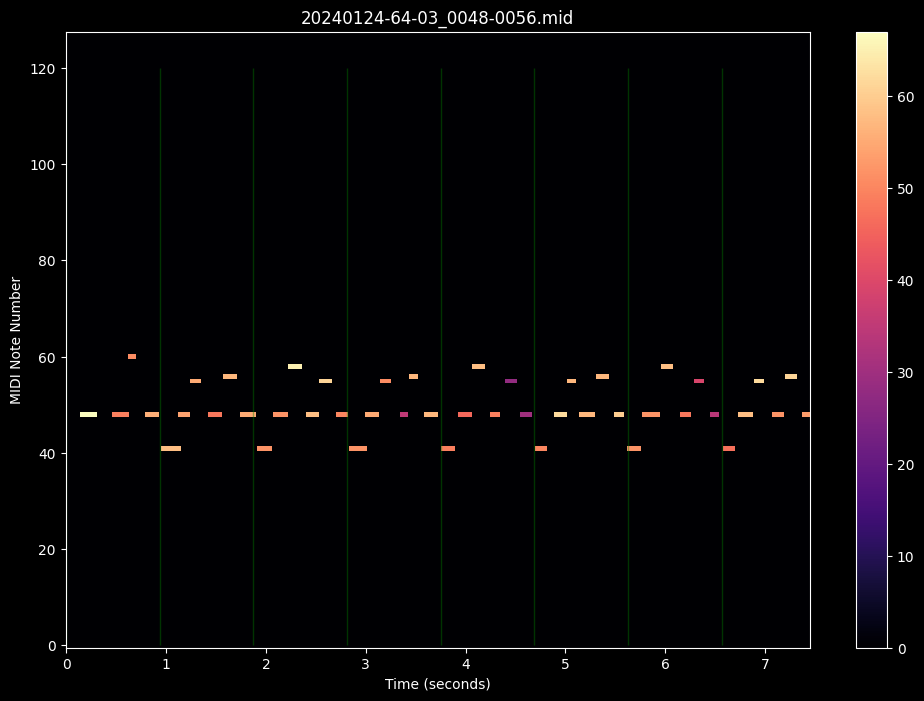

removed set tempo message MetaMessage('set_tempo', tempo=937499, time=0)
adding message (tempo=80) MetaMessage('set_tempo', tempo=750000, time=0)


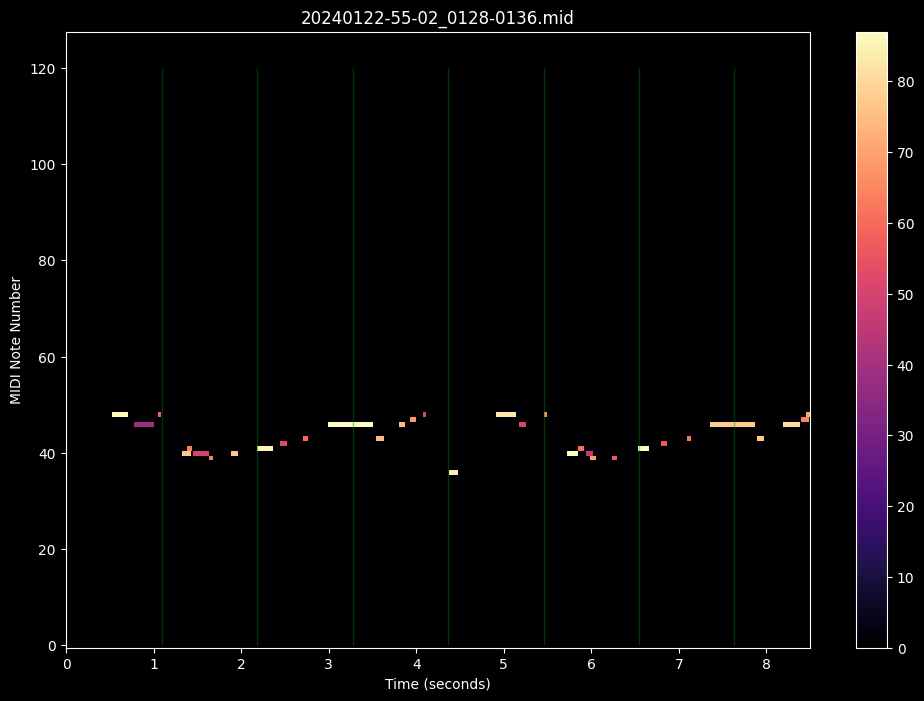

removed set tempo message MetaMessage('set_tempo', tempo=1090909, time=0)
adding message (tempo=80) MetaMessage('set_tempo', tempo=750000, time=0)


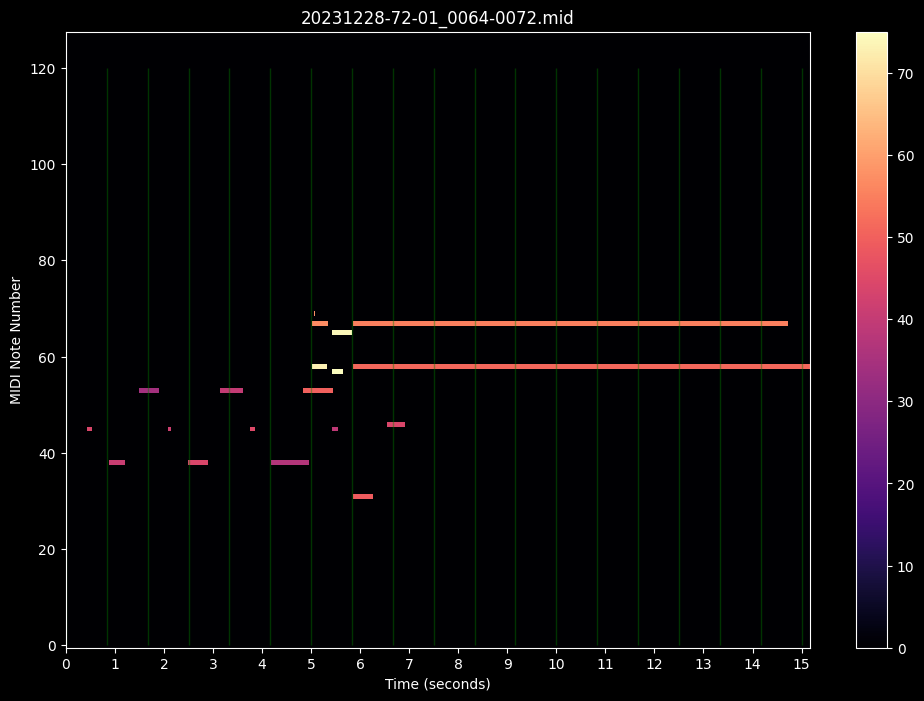

removed set tempo message MetaMessage('set_tempo', tempo=833333, time=0)
adding message (tempo=80) MetaMessage('set_tempo', tempo=750000, time=0)


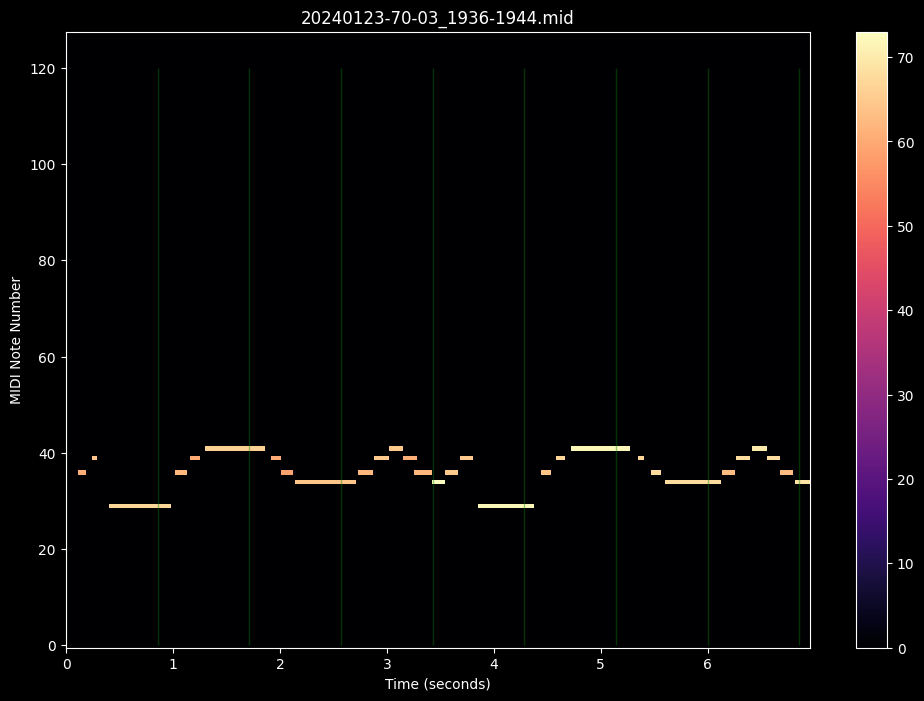

removed set tempo message MetaMessage('set_tempo', tempo=857142, time=0)
adding message (tempo=80) MetaMessage('set_tempo', tempo=750000, time=0)


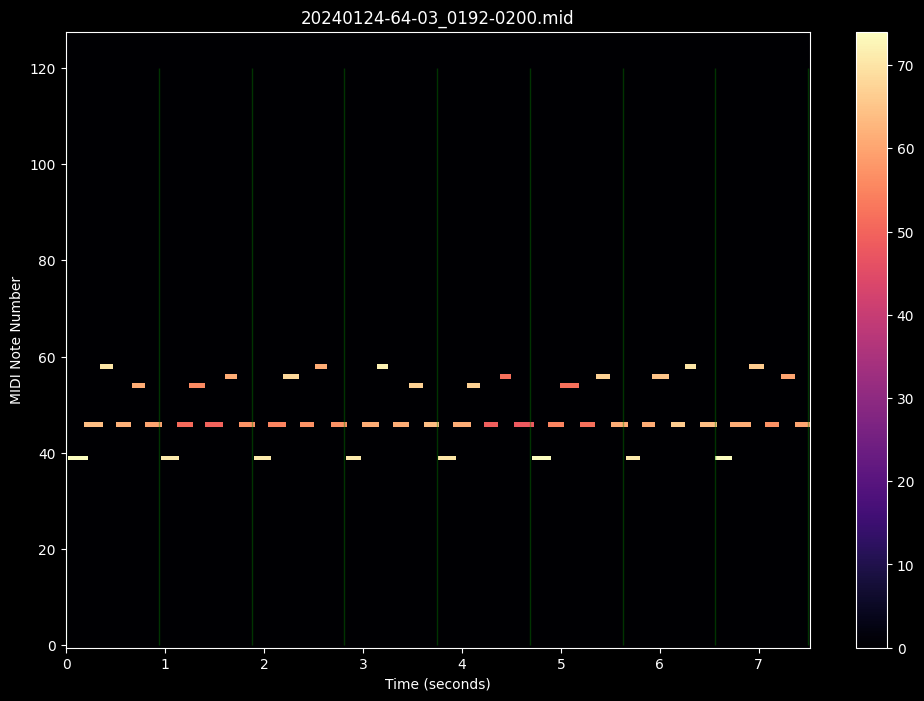

removed set tempo message MetaMessage('set_tempo', tempo=937499, time=0)
adding message (tempo=80) MetaMessage('set_tempo', tempo=750000, time=0)


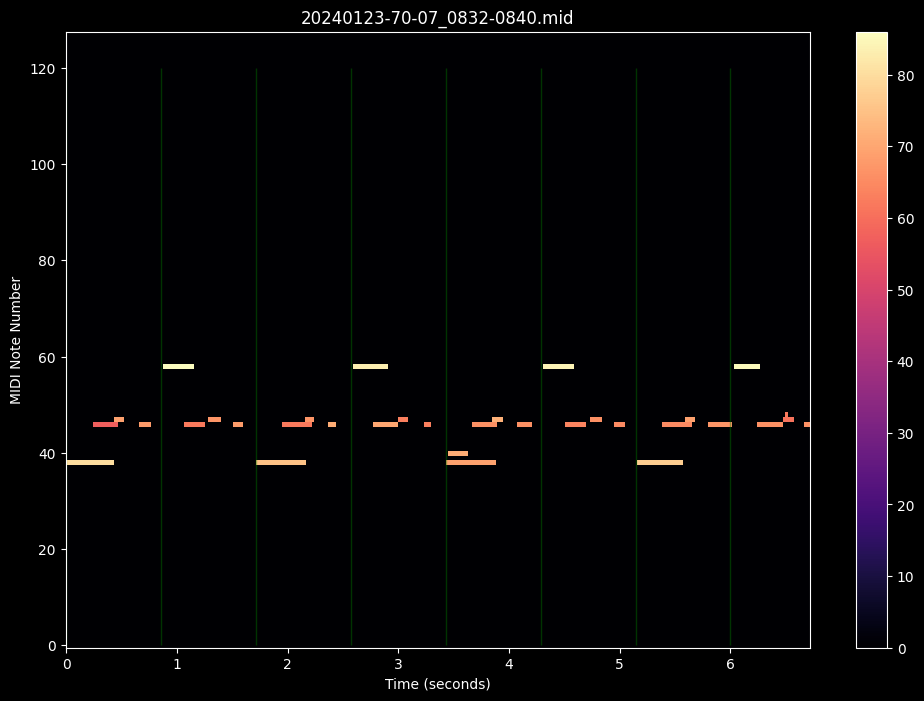

removed set tempo message MetaMessage('set_tempo', tempo=857142, time=0)
adding message (tempo=80) MetaMessage('set_tempo', tempo=750000, time=0)


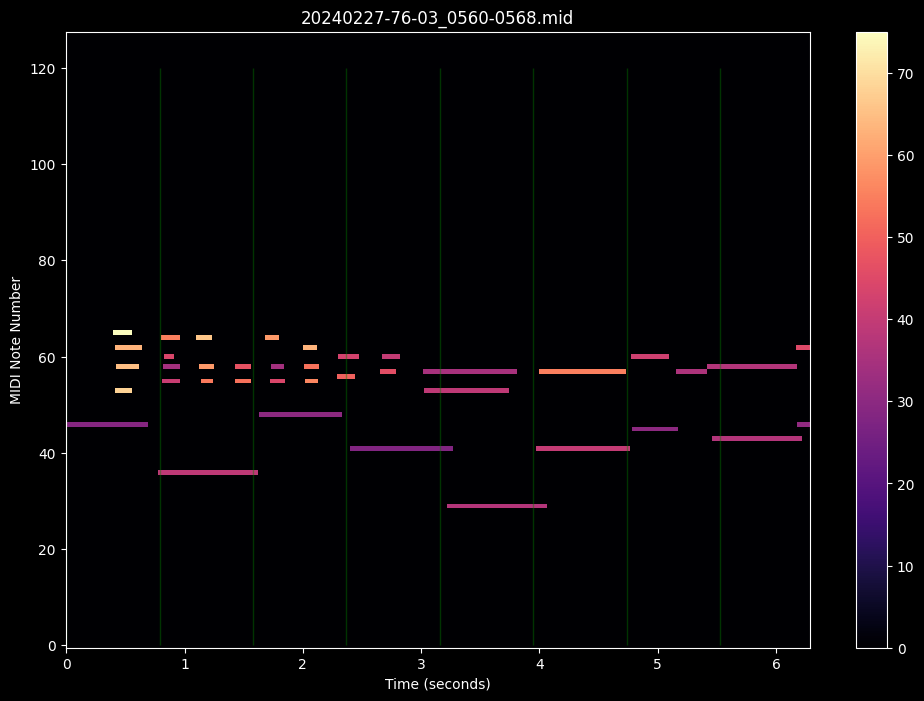

removed set tempo message MetaMessage('set_tempo', tempo=789473, time=0)
adding message (tempo=80) MetaMessage('set_tempo', tempo=750000, time=0)


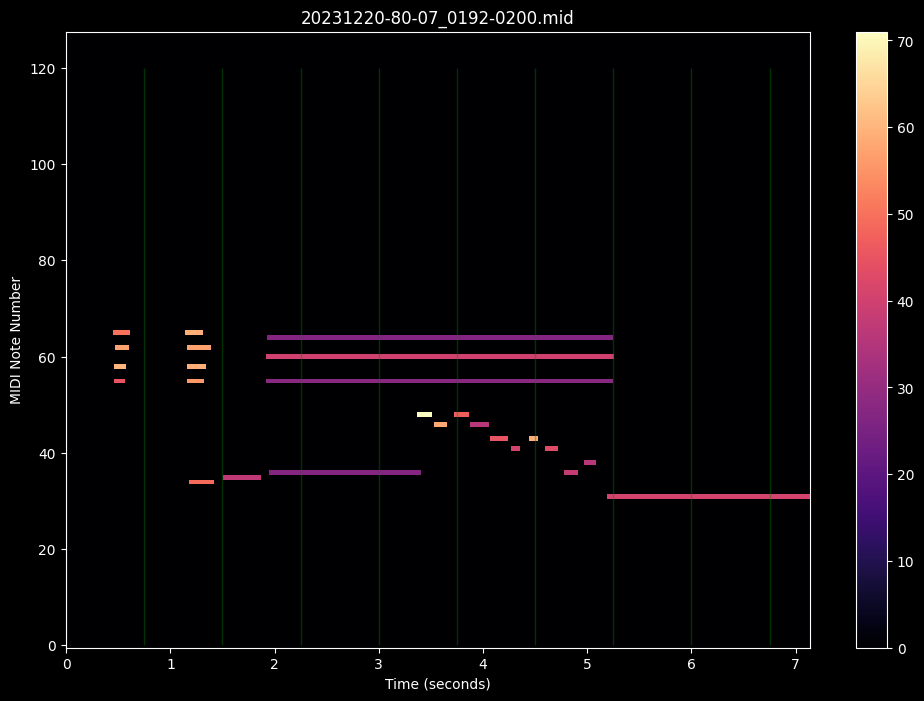

removed set tempo message MetaMessage('set_tempo', tempo=750000, time=0)
adding message (tempo=80) MetaMessage('set_tempo', tempo=750000, time=0)


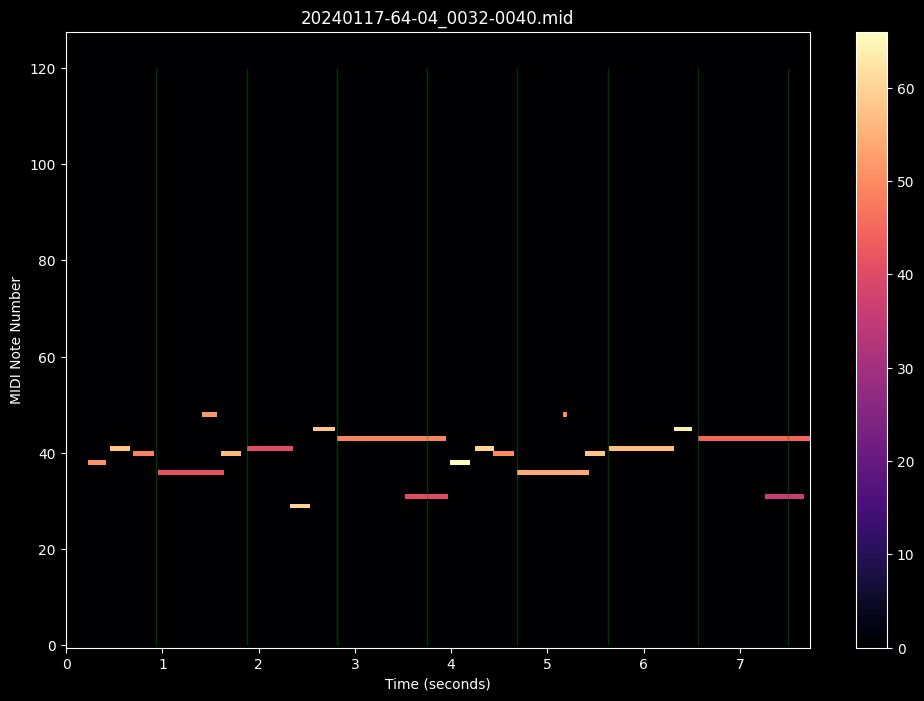

removed set tempo message MetaMessage('set_tempo', tempo=937499, time=0)
adding message (tempo=80) MetaMessage('set_tempo', tempo=750000, time=0)


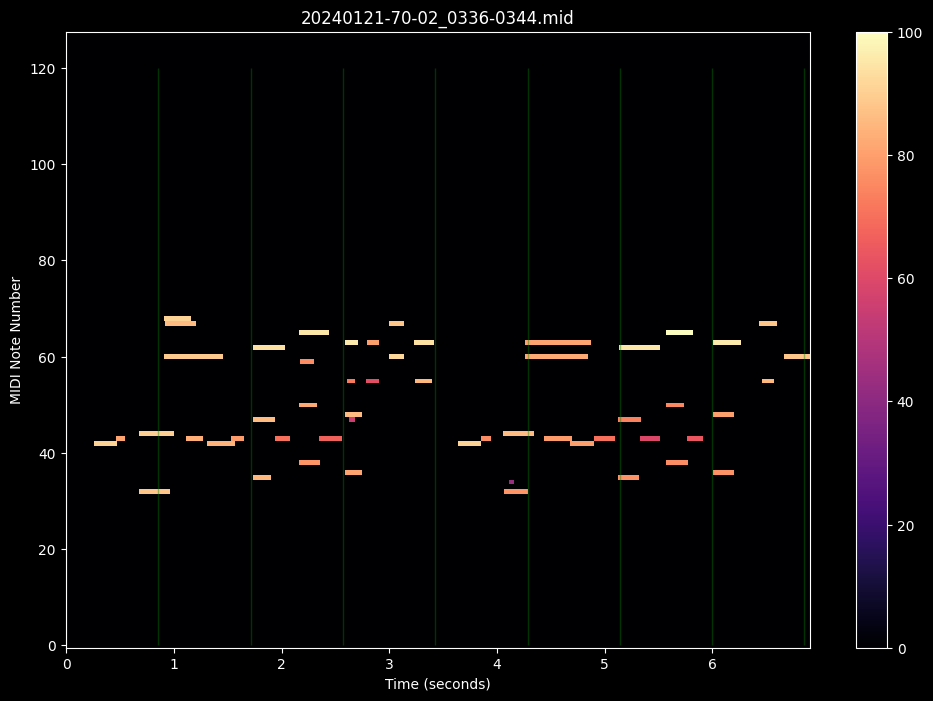

removed set tempo message MetaMessage('set_tempo', tempo=857142, time=0)
adding message (tempo=80) MetaMessage('set_tempo', tempo=750000, time=0)


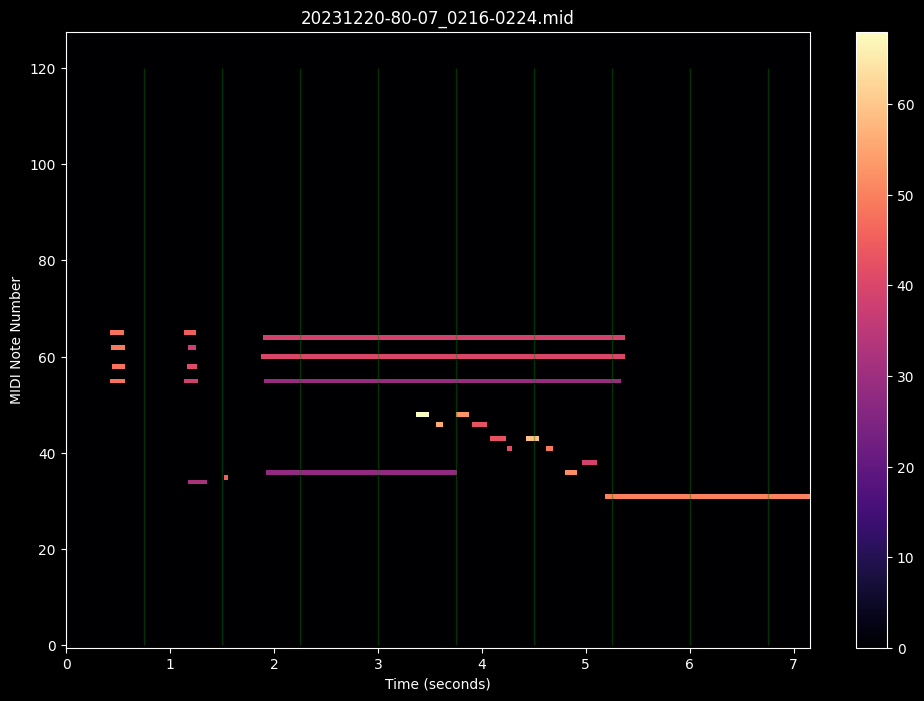

removed set tempo message MetaMessage('set_tempo', tempo=750000, time=0)
adding message (tempo=80) MetaMessage('set_tempo', tempo=750000, time=0)


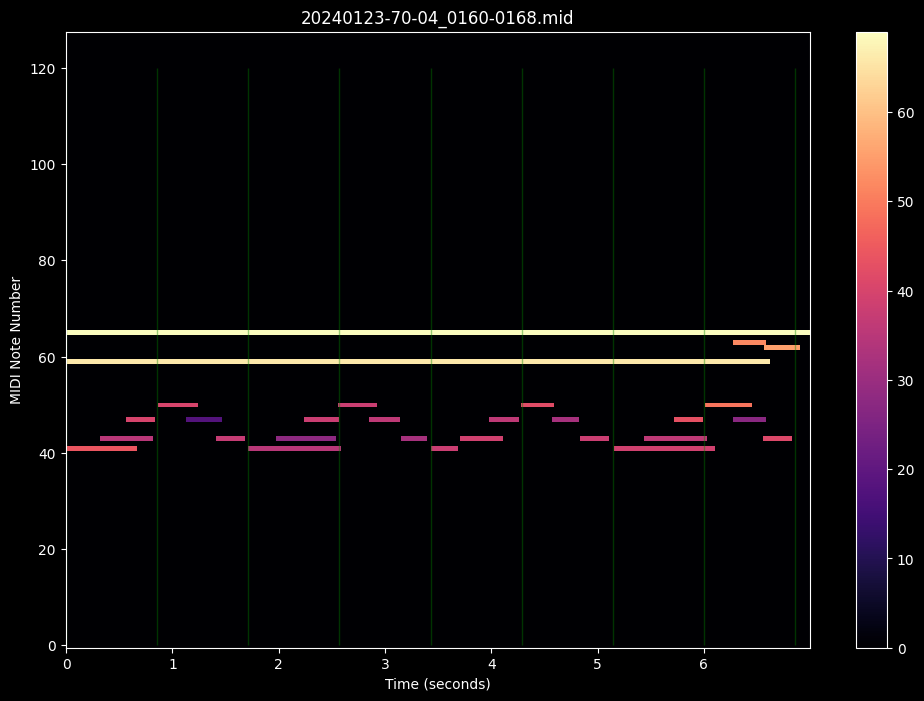

removed set tempo message MetaMessage('set_tempo', tempo=857142, time=0)
adding message (tempo=80) MetaMessage('set_tempo', tempo=750000, time=0)


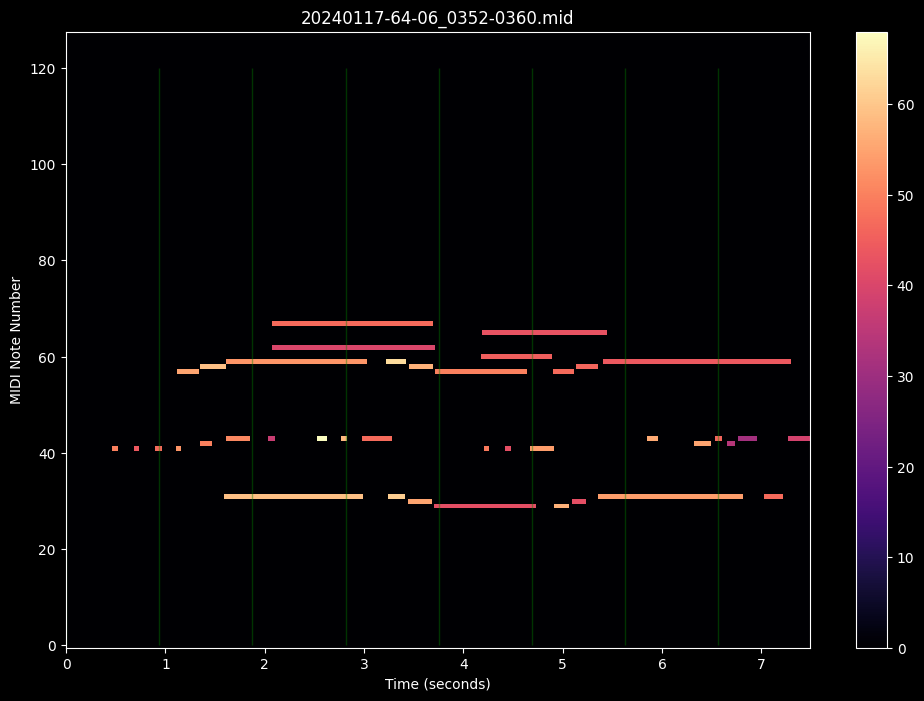

removed set tempo message MetaMessage('set_tempo', tempo=937499, time=0)
adding message (tempo=80) MetaMessage('set_tempo', tempo=750000, time=0)


KeyboardInterrupt: 

In [14]:
import random

all_segments = os.listdir(dataset_folder)
random.shuffle(all_segments)

for segment in all_segments:
    seg_path = os.path.join(dataset_folder, segment)

    # plot
    pm = pretty_midi.PrettyMIDI(seg_path)
    tempo = int(segment.split("-")[1])
    beats = calc_beats(tempo, 0.0, pm.get_end_time())
    draw_piano_roll(
        pm.get_piano_roll(),
        beats=[b - beats[0] for b in beats],
        title=segment,
    )

    # play
    t_file = change_tempo(seg_path)
    with mido.open_output("Disklavier") as output:
        for message in mido.MidiFile(t_file).play(meta_messages=True):
            # print(message)
            if not message.is_meta:
                output.send(message)
            if message.type == "text":
                tick()
    # mido.MidiFile(os.path.join(dataset_folder, all_segments[0])).print_tracks()